In [1]:
import matplotlib.pyplot as plt
from einops import rearrange

import torch
import torch.nn.functional as F


from monai.transforms import ScaleIntensity
from monai.config import print_config

from scripts.train import LitUnet, CentreDataModule
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping


from scripts.utils import *

#print_config()

%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/


def display_subplot(data, title, ax, cmap="gray"):
    ax.imshow(data, cmap=cmap)
    ax.set_title(title)
    ax.axis('off')

def predict_and_display_examples(model, n, loader, centre, seed=0):
    torch.manual_seed(seed)
    batch = next(iter(loader))
    x, y = batch

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    x = x.to(device)

    with torch.no_grad():
        model.eval()
        pred = model(x)
    prob = F.softmax(pred, dim=1)
    y_pred = torch.argmax(prob, dim=1).cpu()

    fig, axes = plt.subplots(3, 1, figsize=(n, 5))
    fig.suptitle(f"Image Predictions and Ground Truth for center {centre}", fontsize=16)
    
    display_subplot(rearrange(x.cpu()[:n+1], "b c h w -> h (b w) c"), "Images", axes[0])
    display_subplot(rearrange(y_pred[:n+1], "b h w -> h (b w)"), "Predictions", axes[1], cmap="viridis")
    display_subplot(rearrange(y[:n+1], "b h w -> h (b w)"), "Ground Truth", axes[2], cmap="viridis")

    plt.tight_layout()
    plt.show()

/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_directory = "Data/M&Ms/OpenDataset"
transform =  ScaleIntensity(minv=0.0, maxv=1.0, channel_wise=True)
torch.manual_seed(42)
dm = CentreDataModule("A", train_centre=6, transform=transform, batch_size=8)


In [14]:
torch.manual_seed(42)
model = LitUnet(lr=1e-3)

# Training and Validation
trainer = pl.Trainer(max_epochs=50, 
                     deterministic=True, 
                     logger=True,
                     log_every_n_steps=2, 
                     enable_model_summary=False,
                     callbacks=[EarlyStopping('val_loss')], 
                     fast_dev_run=False)
trainer.fit(model, datamodule=dm)
trainer.save_checkpoint("checkpoints/benchmark.ckpt")

/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-pac ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


total number of samples: 95, train samples: 76, Validation: 19


100%|██████████| 76/76 [00:01<00:00, 72.27it/s]
/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /home/ids/mahdi-22/M-M/lightning_logs/version_39011/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 13: 100%|██████████| 222/222 [00:12<00:00, 17.48it/s, v_num=39011, val_loss=0.0371, train_loss=0.0416]


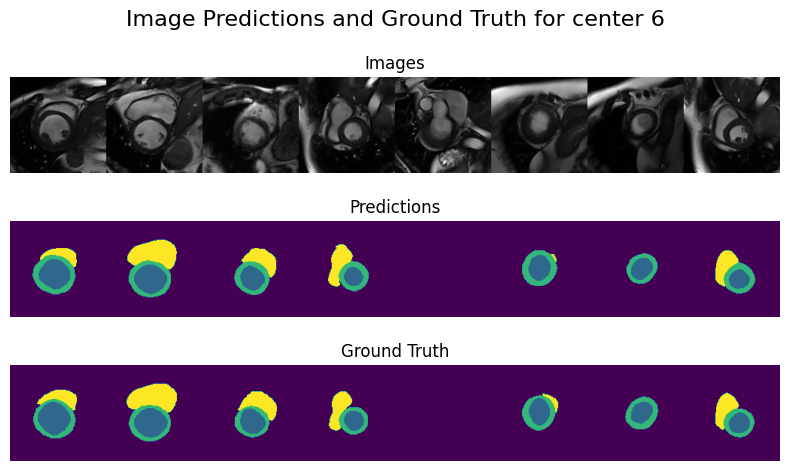

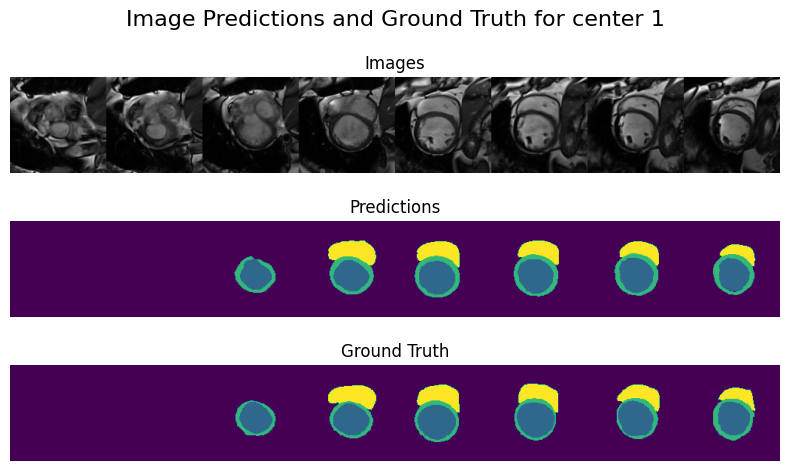

In [16]:
model = LitUnet.load_from_checkpoint("benchmark.ckpt")
n = 20

train_dataloader = dm.train_dataloader()
predict_and_display_examples(model, 8, train_dataloader, 6, seed=0)

val_dataloader = dm.val_dataloader()
predict_and_display_examples(model, 8, val_dataloader, 1, seed=0)

In [14]:
metadata

,VendorName,Vendor,Centre,ED,ES,Age,Pathology,Sex,Height,Weight,Image_path,Seg_path,time_dim,x_dim,y_dim,z_dim,x_pixdim,y_pixdim,z_pixdim
SubjectID,,,,,,,,,,,,,,,,,,,
A0S9V9,Siemens,A,1,0,9,67,DCM,M,180.0,88.0,Data_original/OpenDataset/Training/Labeled/A0S...,Data_original/OpenDataset/Training/Labeled/A0S...,25,216,256,13,1.328125,1.328125,9.52
A1D0Q7,Philips,B,2,0,9,79,HCM,F,NaN,88.0,Data_original/OpenDataset/Training/Labeled/A1D...,Data_original/OpenDataset/Training/Labeled/A1D...,30,320,320,10,1.182432,1.182432,10.00
A1D9Z7,Siemens,A,1,22,11,53,HCM,M,175.0,75.0,Data_original/OpenDataset/Training/Labeled/A1D...,Data_original/OpenDataset/Training/Labeled/A1D...,25,208,256,13,1.250000,1.250000,8.80
A1E9Q1,Siemens,A,1,0,9,16,DCM,M,175.0,75.0,Data_original/OpenDataset/Training/Labeled/A1E...,Data_original/OpenDataset/Training/Labeled/A1E...,25,208,256,13,0.976562,0.976562,10.00
A1K2P5,Canon,D,5,33,11,35,DCM,F,170.0,NaN,Data_original/OpenDataset/Testing/A1K2P5/A1K2P...,Data_original/OpenDataset/Testing/A1K2P5/A1K2P...,34,512,440,14,0.795500,0.795500,10.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T2Z1Z9,Canon,D,5,29,9,43,HCM,F,162.0,93.0,Data_original/OpenDataset/Testing/T2Z1Z9/T2Z1Z...,Data_original/OpenDataset/Testing/T2Z1Z9/T2Z1Z...,30,512,440,12,0.795500,0.795500,10.00
T9U9W2,Siemens,A,1,0,10,57,HCM,M,160.0,68.0,Data_original/OpenDataset/Training/Labeled/T9U...,Data_original/OpenDataset/Training/Labeled/T9U...,25,208,256,11,1.250000,1.250000,8.00
V4W8Z5,GE,C,4,19,9,39,Other,F,NaN,55.0,Data_original/OpenDataset/Testing/V4W8Z5/V4W8Z...,Data_original/OpenDataset/Testing/V4W8Z5/V4W8Z...,20,512,512,12,0.781300,0.781300,10.00
